In [1]:
# -*- coding: utf-8 -*-
# @Time    : 2020/12/30 10:07
# @Author  : 智能 1801班水忠益 8207181829

import matplotlib.pyplot as plt
import numpy as np
import functions as F
import xlrd

In [2]:
workbook = xlrd.open_workbook("init_data_100_node/sequencenumber.xlsx")
sheet = workbook.sheets()[0] # 通过索引获取

rowNum = sheet.nrows
colNum = sheet.ncols 

dat = []
for i in range(colNum):
    rowlist = []
    for j in range(rowNum):
        rowlist.append(sheet.cell_value(j, i))
    dat.append(rowlist)
dat = np.asarray(dat)

In [3]:
# 分区数
m = 4
# 坐标范围
limit = 100
# 点的个数
num = len(dat)

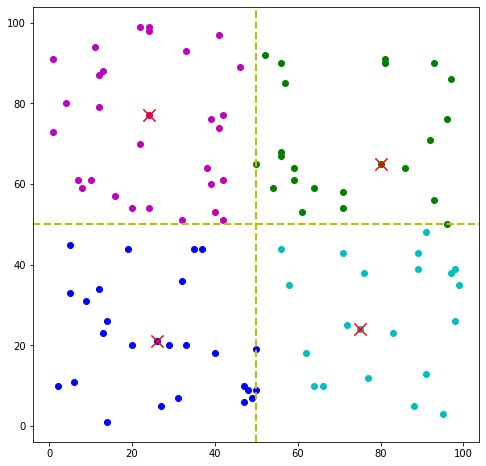

[576. 576.]


In [4]:
# Esc + L 切换行号是否显示
fig, ax = plt.subplots(figsize=(8, 8))

# 一次分区
region1 = np.where((dat[:, 0] < 50) & (dat[:, 1] > 50))[0]
region2 = np.where((dat[:, 0] >= 50) & (dat[:, 1] >= 50))[0]
region3 = np.where((dat[:, 0] <= 50) & (dat[:, 1] <= 50))[0]
region4 = np.where((dat[:, 0] > 50) & (dat[:, 1] < 50))[0]

# 确实是 200个点
# print(region1.size + region2.size + region3.size + region4.size)

regions = [region1, region2, region3, region4]
region_centers = np.array([[25, 75], [75, 75], [25, 25], [75, 25]])

colros = 'mgbc'
centers = []
center_serial_numbers = []
for i in range(4):
    ax.scatter(dat[regions[i], 0], dat[regions[i], 1], marker='o', c=colros[i])
    distance_with_region_center = np.linalg.norm(dat[regions[i], :] - region_centers[i], axis=1, ord=1)
    center_serial_numbers.append(regions[i][np.argmin(distance_with_region_center)])
    centers.append(dat[center_serial_numbers[-1]])
    ax.scatter(centers[-1][0], centers[-1][1], marker="x", s=150, c='r')
xl, xu = ax.get_xlim()
yl, yu = ax.get_ylim()
xm = (xl + xu) / 2
ym = (yl + yu) / 2
ax.plot([xm, xm], [yl, yu], color='y', linestyle='dashed', linewidth=2)
ax.plot([xl, xu], [ym, ym], color='y', linestyle='dashed', linewidth=2)
ax.set_xlim([xl, xu])
ax.set_ylim([yl, yu])
plt.show()
print(fig.get_size_inches()*fig.dpi)

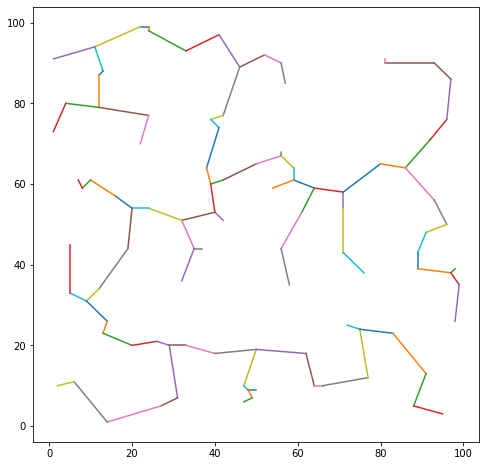

In [5]:
# 计算 D 
distance_matrix = np.zeros((num, num))
for i in range(num):
    for j in range(num):
        distance_matrix[i, j] = np.linalg.norm(dat[i] - dat[j]) 
D = np.full((num, m), m)
D[np.arange(num), np.argmin(distance_matrix[:, center_serial_numbers], axis=1)] = 1

# Prim算法
edges = F.prim(distance_matrix)

# 可视化最小生成树
fig, ax = plt.subplots(figsize=(8, 8))

# 不用繁琐地指定color, 用默认的就可以了
connect_matrix = np.full((num, num), np.inf)
for edge in edges:
    ax.plot([dat[edge[0]][0], dat[edge[1]][0]], [dat[edge[0]][1], dat[edge[1]][1]])
    connect_matrix[edge[0], edge[1]] = 1
    connect_matrix[edge[1], edge[0]] = 1
plt.show()

connect_matrix[np.arange(num), np.arange(num)] = 0
connect_matrix = connect_matrix.tolist()

In [6]:
H = np.full((num, m), m)

distance_djstra = np.zeros((num, m))
for i in range(num):
    distance_djstra[i] = np.asarray(F.startwith(i, connect_matrix))[center_serial_numbers]
H[np.arange(num), np.argmin(distance_djstra, axis=1)] = 1

print(H[:5])

[[1 4 4 4]
 [4 4 1 4]
 [4 4 1 4]
 [4 1 4 4]
 [4 4 1 4]]


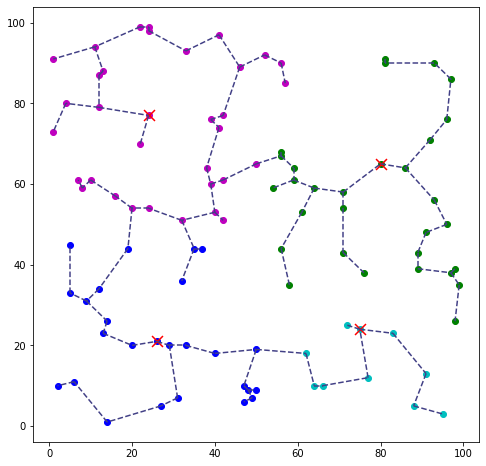

In [7]:
# 二次分区
alpha = 0.5

# 确定归属
W = alpha * D + (1 - alpha) * H
classes = np.argmin(W, axis=1)
sec_regions = []
for i in range(4):
    sec_regions.append(np.where(classes == i)[0])

fig, ax = plt.subplots(figsize=(8, 8))
for i in range(4):
    ax.scatter(dat[sec_regions[i], 0], dat[sec_regions[i], 1], marker='o', c=colros[i])
    ax.scatter(centers[i][0], centers[i][1], marker="x", s=120, c='r')

for edge in edges:
    ax.plot([dat[edge[0]][0], dat[edge[1]][0]], [dat[edge[0]][1], dat[edge[1]][1]], linestyle='--', color='#424086')

plt.show()

In [8]:
coords = []
def onclick(event):
    ix, iy = event.xdata, event.ydata

    global coords
    coords.append((ix, iy))

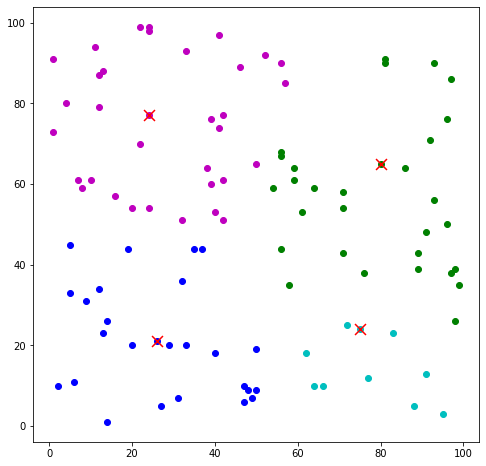

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
fig.canvas.mpl_connect('button_press_event', onclick)

for i in range(4):
    ax.scatter(dat[sec_regions[i], 0], dat[sec_regions[i], 1], marker='o', c=colros[i])
    ax.scatter(centers[i][0], centers[i][1], marker="x", s=120, c='r')

plt.show()

coords = np.asarray(coords)
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(coords[:, 0], coords[:, 1], s=40, c='#00FF00', edgecolors='k')
ax.set_xlim([xl, xu])
ax.set_ylim([yl, yu])

plt.show()

In [9]:
# 代码汇总便于绘制决策边界 -> 每次新进入一个点，进行判断


def partition(dat, alpha):
    region1 = np.where((dat[:, 0] < 50) & (dat[:, 1] > 50))[0]
    region2 = np.where((dat[:, 0] >= 50) & (dat[:, 1] >= 50))[0]
    region3 = np.where((dat[:, 0] <= 50) & (dat[:, 1] <= 50))[0]
    region4 = np.where((dat[:, 0] > 50) & (dat[:, 1] < 50))[0]

    regions = [region1, region2, region3, region4]
    region_centers = np.array([[25, 75], [75, 75], [25, 25], [75, 25]])

    centers = []
    center_serial_numbers = []
    for i in range(4):
        distance_with_region_center = np.linalg.norm(dat[regions[i], :] - region_centers[i], axis=1, ord=1)
        center_serial_numbers.append(regions[i][np.argmin(distance_with_region_center)])
        centers.append(dat[center_serial_numbers[-1]])

    # 计算 D 
    distance_matrix = np.full((num, num), np.inf)
    for i in range(num):
        for j in range(num):
            if i == j:
                continue
            distance_matrix[i, j] = np.linalg.norm(dat[i] - dat[j])

    D = np.full((num, m), m)
    D[np.arange(num), np.argmin(distance_matrix[:, center_serial_numbers], axis=1)] = 1

    edges = F.prim(distance_matrix)

    adjMatrix = np.full((num, num), False)
    for edge in edges:
        adjMatrix[edge[0], edge[1]] = True
        adjMatrix[edge[1], edge[0]] = True
    adjMatrix[np.arange(num), np.arange(num)] = True
    distance_matrix[distance_matrix == np.inf] = 0

    H = np.full((num, m), m)

    distance_matrix1 = np.full((num, num), np.inf) 
    distance_matrix1[adjMatrix] = distance_matrix[adjMatrix]
    distance_matrix1 = distance_matrix1.tolist()

    distance_djstra = np.zeros((num, m))
    for i in range(num):
        distance_djstra[i] = np.asarray(F.startwith(i, distance_matrix1))[center_serial_numbers]
    H[np.arange(num), np.argmin(distance_djstra, axis=1)] = 1

    W = alpha * D + (1 - alpha) * H
    classes = np.argmin(W, axis=1)
    sec_regions = []
    for i in range(4):
        sec_regions.append(np.where(classes == i)[0])

    colros = 'mgbc'
    fig, ax = plt.subplots(figsize=(8, 8))
    for i in range(4):
        ax.scatter(dat[sec_regions[i], 0], dat[sec_regions[i], 1], marker='o', c=colros[i])
        ax.scatter(centers[i][0], centers[i][1], marker="x", s=120, c='r')

    for edge in edges:
        ax.plot([dat[edge[0]][0], dat[edge[1]][0]], [dat[edge[0]][1], dat[edge[1]][1]], linestyle='--', color='#424086')

    # plt.show()
    return classes[-1]

In [10]:
# 每次新加入一个点进去
# labels = []
# add_pts = []
# for i in range(1000):
#     for j in range(1000):
#         add_pts.append([i / 10, j / 10])
#         labels.append(partition(np.concatenate([dat, [[i / 10, j / 10]]], axis=0), 0.5))

# # 绘制决策域
# colros = 'mgbc'
# fig, ax = plt.subplots(figsize=(8, 8))
# region1 = np.where(labels == 0)[0]
# region2 = np.where(labels == 1)[0]
# region3 = np.where(labels == 2)[0]
# region4 = np.where(labels == 3)[0]
# decision_regions = [region1, region2, region3, region4]
# for i in range(4):
#     ax.scatter(add_pts[decision_regions[i], 0], dat[decision_regions[i], 1], marker='o', c=colros[i])


3

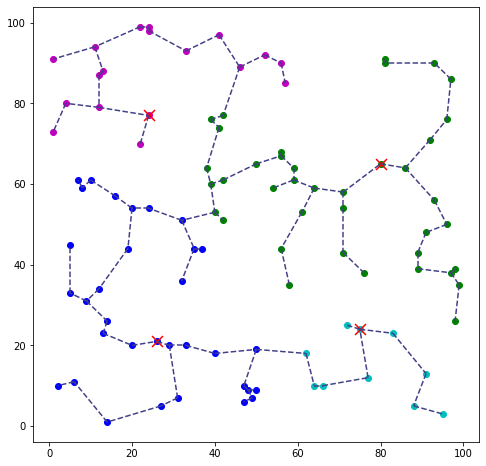

In [11]:
# 基于最小生成树进行分区
# alpha = 0
partition(dat, 0)